# Visualising slices of the GPR fit

We want to visualise the relationship between inputs and outputs in this GPR model, in particular the GP uncertainy around the points. 


In [1]:
# import packages
import os, sys, platform
import numpy as np
import pandas as pd
import scipy as sp
import GPy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ternary
import warnings
warnings.filterwarnings('ignore')
print('Python version', sys.version)
print('Running on', platform.system())

Python version 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Running on Darwin


In [2]:
#General GPy function
#=========================================
def gpy_func(X, y):
    """
    Function performs the GP regression. 
    The inputs X and y are the input and output pairs.
    """
    n = X.shape[0] # number of data points
    d = X.shape[1] # dimension of input
    
    # build kernel
    k_rbf = GPy.kern.RBF(input_dim=d,
                         ARD=True,
                         lengthscale=X.std(axis=0),
                         variance=y.var()/2) ######MULTIDIMENSIONAL VARIANCE

    kernel = k_rbf
    
    # priors
    prior_uniform = GPy.priors.Uniform(0,1000)
    prior_gamma = GPy.priors.Gamma(a=1,b=1)
    
    # likelihood
    lik = GPy.likelihoods.Gaussian()
    
    # initially construct the model
    gpm = GPy.core.GP(    X=X, 
                          Y=y,
                          likelihood=lik,
                          kernel=kernel)
    
    # set priors
    for j in range(X.shape[1]):
        gpm.kern.lengthscale[[j]].set_prior(prior_uniform, warning=False)
        gpm.kern.lengthscale[[j]] = X[:,j].std()*(2**.5) # start within the prior
    
    gpm.kern.variance.set_prior(prior_gamma, warning=False)
    gpm.likelihood.variance.set_prior(prior_gamma, warning=False)
    
    # optimize the hyperparameters
    for i in range(0,20): # OPTIMIZE 10x,20x?
        gpm.optimize()
    
    return gpm

# COMPOSITIONS -> GPM -> PROPERTIES
#=========================================
def load_reverseGPM(training_file,dvk):
    """
    Function organises the physicochemical training data
    into input and outputs, and trains the gpm using the
    gpy_func()
    """
    
    #Training data organising
    F = pd.read_csv(training_file)

    df = F.sort_values(["xEC", "xLiPF6", "Temp"], ascending = (False, False, True)) #Groups same composition properties together in ascending temperatures
    data = df.to_numpy()
    
    # properties = data[:,5:] #all properties
    properties = data[:,dvk+4]
    compositions = data[:,[2,4]] #LiPF6, EC, EMC all included
    
    properties = np.array(np.split(properties,np.arange(5,len(data),5))) #Subarray every 5 temps
    properties = np.array([i.flatten() for i in properties])
    
    compositions = np.array(np.split(compositions,np.arange(5,len(data),5))) #Subarray every 5 temps
    compositions = np.array([np.mean(i,0) for i in compositions])
    
    #GPM training
    Y = properties #Model training outputs
    X = compositions #Model training inputs

    n = X.shape[0] #number of rows of data
    d = X.shape[1] #dimensions of each data point

    gpm = gpy_func(X,Y)
    
    return gpm, compositions, properties

In [11]:
#Generate an array of the compositions that we slice over
#===========================================================
def generate_x_slice(ratio_lock,n_slice):
    #Get minimum and maximum composition ranges
    
    #Keep the slices generally interpolating within the training range
    Li_minmax = np.array([0,0.25])
    EMC_minmax = np.array([0.2,1])
    EC_minmax = np.array([0,0.7])
    
    position = np.where(ratio_lock == 0)[0][0] #Will throw error if ratio_lock is wrong

    if position == 0: #Vary Li composition with fixed EC:EMC ratio
        EC_split = ratio_lock[1]/sum(ratio_lock)
        Li_range = np.linspace(Li_minmax[0], Li_minmax[1], n_slice)
        EC_range = (1-Li_range)*EC_split
        EMC_range = 1-Li_range-EC_range
        x_array = np.stack((Li_range,EC_range,EMC_range),axis=1)

    elif position == 1: #Vary EC composition with fixed Li:EMC ratio
        Li_split = ratio_lock[0]/sum(ratio_lock)
        EC_range = np.linspace(EC_minmax[0], EC_minmax[1], n_slice)
        Li_range = (1-EC_range)*Li_split
        EMC_range = 1-Li_range-EC_range
        x_array = np.stack((Li_range,EC_range,EMC_range),axis=1)    

    elif position == 2: #Vary EMC composition with fixed Li:EC ratio
        Li_split = ratio_lock[0]/sum(ratio_lock)
        EMC_range = np.linspace(EMC_minmax[0], EMC_minmax[1], n_slice)
        Li_range = (1-EMC_range)*Li_split
        EC_range = 1-Li_range-EMC_range
        x_array = np.stack((Li_range,EC_range,EMC_range),axis=1)
        
    return x_array

#Visualise the slice on a ternary diagram
#===========================================================
def plot_ternary(x_data):
    # colours (From Birmingham With Love)
    jade = np.array([0, .66, .436]) # statue green
    blue = np.array([.057, .156, .520]) # hey there mr blue
    brown = np.array([.515, .158, .033]) # did someone order CDM?
    red = np.array([.85, .20, 0]) # tikka masala
    gold = np.array([1, .67, .14]) # Staffordshire hoard
    claret = np.array([.429, .073, .238]) # claret
    grey = np.array([.585, .612, .675]) # library grey
    black = np.array([0,0,0]) # this is a black
    
    training_file = 'trainingset/Ternary_Physicochemical_Training.csv'
    
    import ternary
    fig = ternary.plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(2, 1, 2)
    
    tax = ternary.TernaryAxesSubplot(ax=ax,scale=30)
    axes_colors = {'b': 'k', 'r': 'k', 'l': 'k'}
    tax.boundary(linewidth=1.0, axes_colors=axes_colors)
    tax.gridlines(color="k", multiple=10, linewidth=0.5, ls='-')
    tax.ax.axis("equal")
    tax.ax.axis("off")

    fontsize = 16
    # tax.set_title("Zoomed region",color='r')
    tax.left_axis_label("EC", fontsize=fontsize, offset=0.17, color='k')
    tax.right_axis_label("EMC", fontsize=fontsize, offset=0.17, color='k')
    tax.bottom_axis_label("LiPF6", fontsize=fontsize, offset=0.03, color='k')

    tax.set_axis_limits({'b': [0, 1], 'l': [0, 1], 'r': [0, 1]})
    tax.get_ticks_from_axis_limits(multiple=7)
    tick_formats = "%.2f"
    tax.set_custom_ticks(fontsize=10, offset=0.025, multiple=5,
                          axes_colors=axes_colors, tick_formats=tick_formats)
    
    #Get the training data points
    df = pd.read_csv(training_file)
    training = df[['xLiPF6','xEMC','xEC']].to_numpy()
    
    #SLICE DATA
    points = np.stack((x_data[:,0],x_data[:,2],x_data[:,1]),axis=1)
    points_c = tax.convert_coordinates(points, axisorder='blr')
    tax.scatter(points_c, marker='^', s=25, color=blue)
    #TRAINING DATA
    points = training
    points_c = tax.convert_coordinates(points, axisorder='blr')
    tax.scatter(points_c, marker='x', s=25, color=red)

    fig.set_facecolor("w")
    tax.ax.set_position([0.50, 0.05, 0.46, 0.8])
    tax.resize_drawing_canvas()
    ternary.plt.show()
    
    
#Predict properties and visualise fit
#===========================================================
def sliced_properties(x_data,Temp,prop_choice):
    #Organise input compositions
    x = x_data[:,[0,2]] # [Li, EMC] input data

    #Training data
    training_file = 'trainingset/Ternary_Physicochemical_Training.csv'

    #Which properties dvk in training output
    if prop_choice == 'd':
        dvk = np.array([1]) #1,2,3 = all dvk, 1=d
    elif prop_choice == 'v':
        dvk = np.array([2]) #1,2,3 = all dvk, 1=d
    elif prop_choice == 'k':
        dvk = np.array([3]) #1,2,3 = all dvk, 1=d       

    #Model training
    gpm, compositions, properties = load_reverseGPM(training_file, dvk)

    props, var = gpm.predict(x) #make prediction
    sd = (np.sqrt(var)/np.mean(props))*props
    
    i = np.where(np.array([10,20,25,30,40]) == Temp)[0][0] #Which temperature column is it

    props = props[:,i]
    sd = sd[:,i]
    
    return props, sd

#Plotting the variance and predicted values for the GPR
#===========================================================
def plot_GPR_fit(x_data, Temperature, x, xlabel):
    
    # colours (From Birmingham With Love)
    jade = np.array([0, .66, .436]) # statue green
    blue = np.array([.057, .156, .520]) # hey there mr blue
    brown = np.array([.515, .158, .033]) # did someone order CDM?
    red = np.array([.85, .20, 0]) # tikka masala
    gold = np.array([1, .67, .14]) # Staffordshire hoard
    claret = np.array([.429, .073, .238]) # claret
    grey = np.array([.585, .612, .675]) # library grey
    black = np.array([0,0,0]) # this is a black

    #Plotting
    fig, ax = plt.subplots(1,3,figsize=(15,2.5))
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    #PLOT DENSITY
    props, sd = sliced_properties(x_data,Temperature,'d')
    ax[0].set_title('Density (' + str(Temperature) + '°C)')
    ax[0].fill_between(x,props+sd,props-sd,color=jade,alpha=0.5)
    ax[0].plot(x,props,color=jade)
    ax[0].set_xlim(np.array([np.min(x),np.max(x)]));
    ax[0].set_ylim([1,1.5]);
    ax[0].set_ylabel('Dens. [g/cm$^3$]', fontsize=12)
    ax[0].set_xlabel(xlabel, fontsize=12)

    #PLOT Viscosty
    props, sd = sliced_properties(x_data,Temperature,'v')
    ax[1].set_title('Viscosity (' + str(Temperature) + '°C)')
    ax[1].fill_between(x,props+sd,props-sd,color=blue,alpha=0.5)
    ax[1].plot(x,props,color=blue)
    ax[1].set_xlim(np.array([np.min(x),np.max(x)]));
    ax[1].set_ylim([0,90]);
    ax[1].set_ylabel('Visc. [cP]', fontsize=12)
    ax[1].set_xlabel(xlabel, fontsize=12)

    #PLOT Conductivity
    props, sd = sliced_properties(x_data,Temperature,'k')
    ax[2].set_title('Conductivity (' + str(Temperature) + '°C)')
    ax[2].fill_between(x,props+sd,props-sd,color=red,alpha=0.5)
    ax[2].plot(x,props,color=red)
    ax[2].set_xlim(np.array([np.min(x),np.max(x)]));
    ax[2].set_ylim([0,15]);
    ax[2].set_ylabel('Cond. [mS/cm]', fontsize=12)
    ax[2].set_xlabel(xlabel, fontsize=12)
    plt.show()

---
### Generate slice compositions, predict properties, and visualise fit

#### 1. Solvent ratios near the training points
This scenario is similar to those used in the manuscript to identify cosolvent segregation. Variation is visualized as a function of **Li mass fraction**.

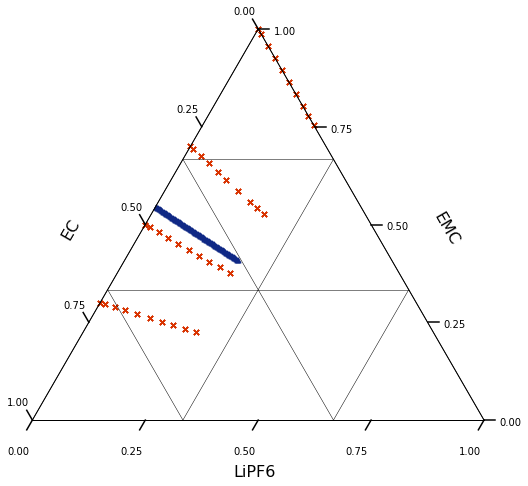

In [32]:
ratio_lock = np.array([0,5,6]) # Li, EC, EMC. Vary whichever is set at 0, fix the other 2 ratios together.
n_slice = 100
x_data = generate_x_slice(ratio_lock,n_slice) #composition array
plot_ternary(x_data) #See the slice on a ternary chart

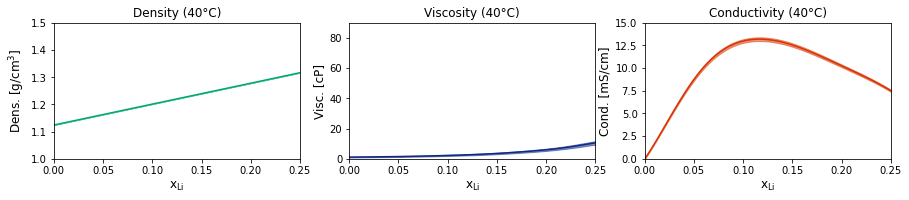

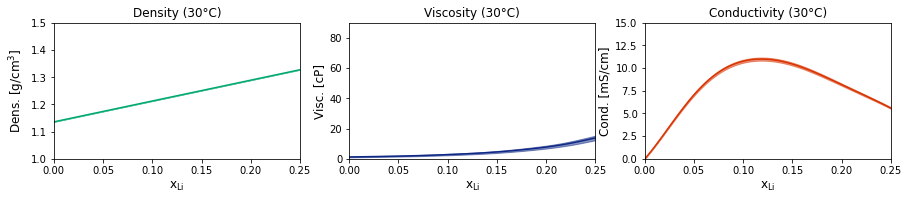

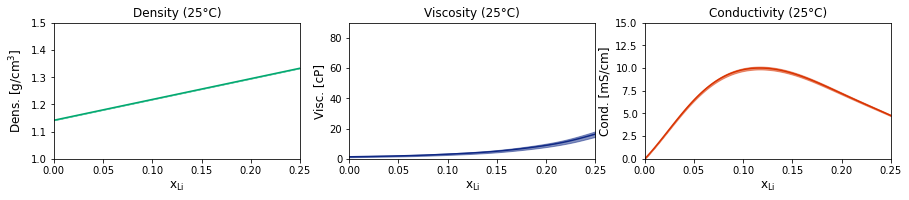

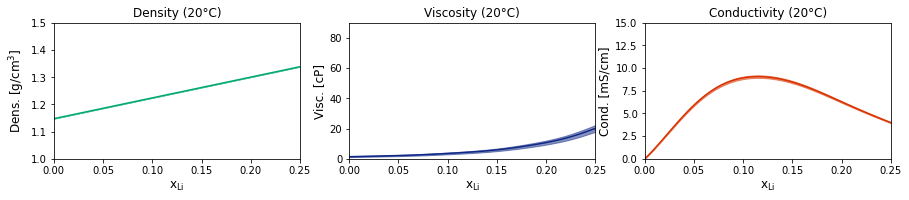

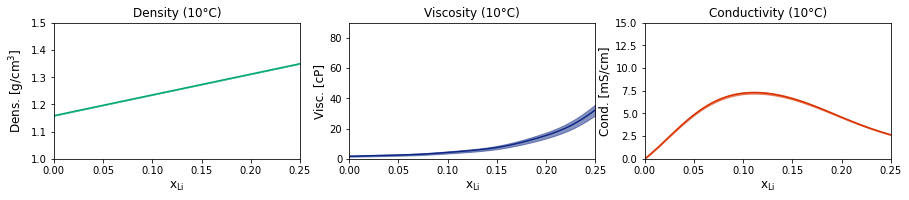

In [33]:
#Composition mass fractions
xLi = x_data[:,0]
xEC = x_data[:,1]
xEMC = x_data[:,2]

x = xLi #Chosen x-axis
xlabel = '$x_{Li}$'

#Show all temperatures
plot_GPR_fit(x_data, 40, x, xlabel)
plot_GPR_fit(x_data, 30, x, xlabel)
plot_GPR_fit(x_data, 25, x, xlabel)
plot_GPR_fit(x_data, 20, x, xlabel)
plot_GPR_fit(x_data, 10, x, xlabel)

#### 2. Slicing through several solvent ratios within the training space
This scenario visualizes variance in properties across the entire training space as a function of the **EC/EMC ratio**
However, from the slice it is clear that salt content is also changing.

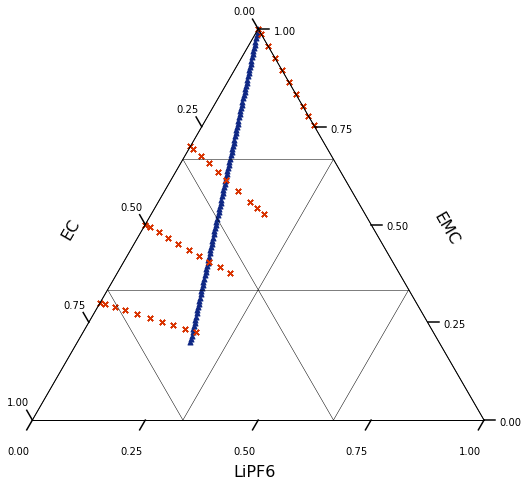

In [28]:
ratio_lock = np.array([1,2.2,0]) # Li, EC, EMC. Vary whichever is set at 0, fix the other 2 ratios together.
n_slice = 100
x_data = generate_x_slice(ratio_lock,n_slice) #composition array
plot_ternary(x_data) #See the slice on a ternary chart

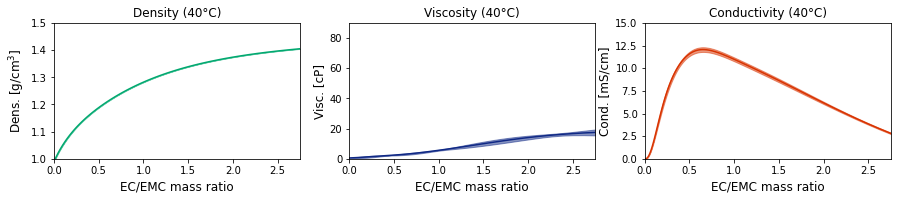

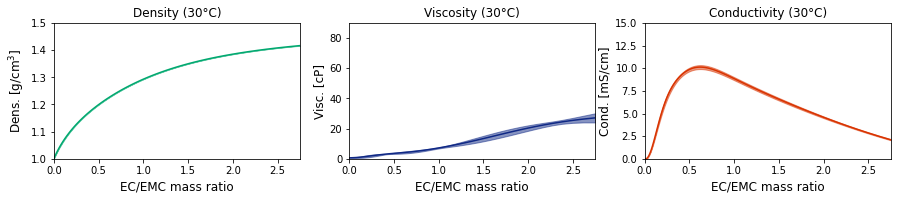

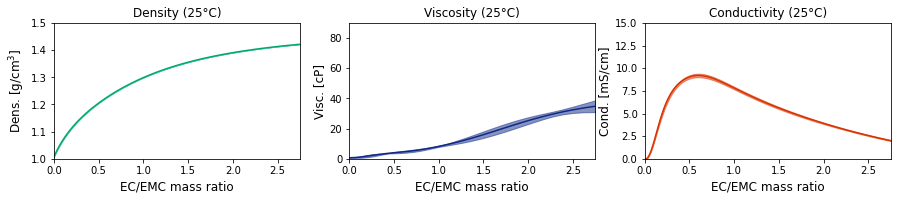

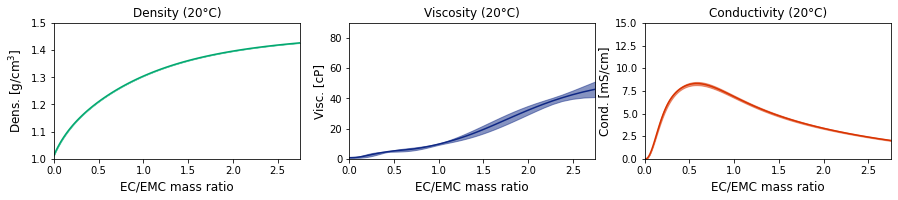

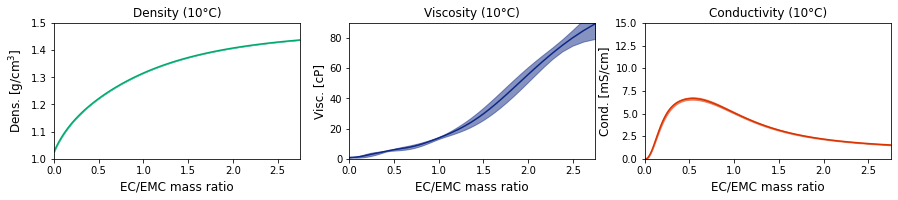

In [29]:
#Composition mass fractions
xLi = x_data[:,0]
xEC = x_data[:,1]
xEMC = x_data[:,2]

x = xEC/xEMC #Chosen x-axis
xlabel = 'EC/EMC mass ratio'

#Show all temperatures
plot_GPR_fit(x_data, 40, x, xlabel)
plot_GPR_fit(x_data, 30, x, xlabel)
plot_GPR_fit(x_data, 25, x, xlabel)
plot_GPR_fit(x_data, 20, x, xlabel)
plot_GPR_fit(x_data, 10, x, xlabel)